In [1]:
import os
import sys
root_folder = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(root_folder)
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from transformers import DecisionTransformerConfig
from decision_transformer.art import AutonomousFreeflyerTransformer
import torch
import decision_transformer.manage as ART_manager
from decision_transformer.manage import device

cuda


# Decision Transformer
Controllare nell'importazione del dataset se la permutation ha fatto in modo che ci siano differenze tra istante finale ed iniziale

In [2]:
model_name_4_saving = 'checkpoint_ff_ctgrtg'
mdp_constr = True
datasets, dataloaders = ART_manager.get_train_val_test_data(mdp_constr=mdp_constr, timestep_norm=False)
train_loader, eval_loader, test_loader = dataloaders
n_state = train_loader.dataset.n_state
n_data = train_loader.dataset.n_data
n_action = train_loader.dataset.n_action
n_time = train_loader.dataset.max_len

Loading data from root/dataset/torch/...Completed, DATA IS NOT SHUFFLED YET.



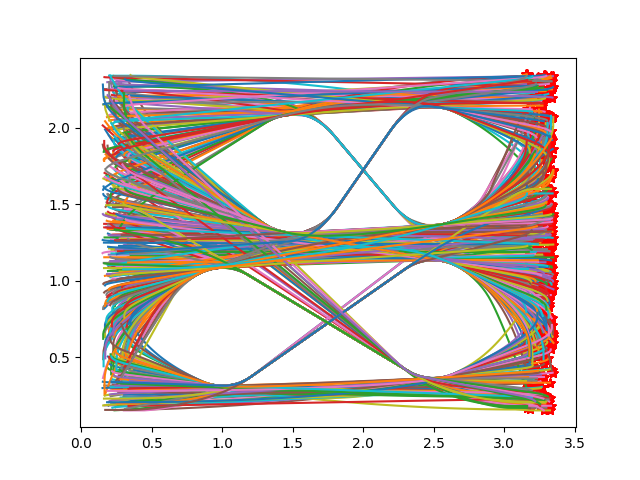

In [3]:
import matplotlib.pyplot as plt
%matplotlib ipympl
plt.figure()
ax = plt.axes()
data_stats = datasets[0].data_stats
for i in range(1000):
    if datasets[0].data['ctgs'][i,0] == 0:
        ax.plot((datasets[0].data['states'][i,:,0]*data_stats['states_std'][:,0]) + data_stats['states_mean'][:,0], (datasets[0].data['states'][i,:,1]*data_stats['states_std'][:,1]) + data_stats['states_mean'][:,1])
        ax.scatter((datasets[0].data['goal'][i,:,0]*data_stats['goal_std'][:,0]) + data_stats['goal_mean'][:,0], (datasets[0].data['goal'][i,:,1]*data_stats['goal_std'][:,1]) + data_stats['goal_mean'][:,1], marker = '*', color='r')
plt.show()

In [ ]:
config = DecisionTransformerConfig(
    state_dim=n_state, 
    act_dim=n_action,
    hidden_size=384,
    max_ep_len=n_time,
    vocab_size=1,
    action_tanh=False,
    n_positions=1024,
    n_layer=6,
    n_head=6,
    n_inner=None,
    resid_pdrop=0.1,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    )
model = AutonomousFreeflyerTransformer(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT size: {model_size/1000**2:.1f}M parameters")
model.to(device);

In [ ]:
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
accelerator = Accelerator(mixed_precision='no', gradient_accumulation_steps=8)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_loader, eval_loader
)
num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = 10000000000

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=10,
    num_training_steps=num_training_steps,
)

# To activate only when starting from a pretrained model
# accelerator.load_state(root_folder + '/decision_transformer/saved_files/checkpoints/' + model_name_4_dataset)

In [ ]:
eval_iters = 100
@torch.no_grad()
def evaluate():
    model.eval()
    losses = []
    losses_state = []
    losses_action = []
    for step in range(eval_iters):
        data_iter = iter(eval_dataloader)
        states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, _, _, _ = next(data_iter)
        with torch.no_grad():
            state_preds, action_preds = model(
                states=states_i,
                actions=actions_i,
                goal=goal_i,
                returns_to_go=rtgs_i,
                constraints_to_go=ctgs_i,
                timesteps=timesteps_i,
                attention_mask=attention_mask_i,
                return_dict=False,
            )
        loss_i = torch.mean((action_preds - actions_i) ** 2)
        loss_i_state = torch.mean((state_preds[:,:-1,:] - states_i[:,1:,:]) ** 2)
        losses.append(accelerator.gather(loss_i + loss_i_state))
        losses_state.append(accelerator.gather(loss_i_state))
        losses_action.append(accelerator.gather(loss_i))
    loss = torch.mean(torch.tensor(losses))
    loss_state = torch.mean(torch.tensor(losses_state))
    loss_action = torch.mean(torch.tensor(losses_action))
    model.train()
    return loss.item(), loss_state.item(), loss_action.item()

In [ ]:
eval_loss, loss_state, loss_action = evaluate()
accelerator.print({"loss/eval": eval_loss, "loss/state": loss_state, "loss/action": loss_action})

Verificare quali istanti temporali devono essere confrontati per il calcolo delle losses di azione/stato/reward/constraint

In [ ]:

eval_steps = 500
samples_per_step = accelerator.state.num_processes * train_loader.batch_size
torch.manual_seed(4)

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in enumerate(train_dataloader, start=0):
        with accelerator.accumulate(model):
            states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, _, _, _ = batch
            state_preds, action_preds = model(
                states=states_i,
                actions=actions_i,
                goal=goal_i,
                returns_to_go=rtgs_i,
                constraints_to_go=ctgs_i,
                timesteps=timesteps_i,
                attention_mask=attention_mask_i,
                return_dict=False,
            )
            loss_i_action = torch.mean((action_preds - actions_i) ** 2)
            loss_i_state = torch.mean((state_preds[:,:-1,:] - states_i[:,1:,:]) ** 2)
            loss = loss_i_action + loss_i_state
            if step % 100 == 0:
                accelerator.print(
                    {
                        "lr": lr_scheduler.get_lr(),
                        "samples": step * samples_per_step,
                        "steps": completed_steps,
                        "loss/train": loss.item(),
                    }
                )
            accelerator.backward(loss)
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
            if (step % (eval_steps)) == 0:
                eval_loss, loss_state, loss_action = evaluate()
                accelerator.print({"loss/eval": eval_loss, "loss/state": loss_state, "loss/action": loss_action})
                model.train()
                accelerator.wait_for_everyone()
            if (step % (eval_steps*10)) == 0:
                print('Saving model..')
                accelerator.save_state(root_folder+'/decision_transformer/saved_files/checkpoints/'+model_name_4_saving)

TODO: Need to implement inference function to predict with cost-to-go formulation both with dynamics and open-loop

In [ ]:
eval_loss, loss_state, loss_action, loss_reward, loss_constraint = evaluate()
accelerator.print({"loss/eval": eval_loss, "loss/state": loss_state, "loss/action": loss_action, "loss/reward": loss_reward, "loss/constraint": loss_constraint})